# Forced Choice Audio Analogy ConvNet
This notebook has a model trained on an audio analogy task:
`A : B :: C : ?`, where D must be selected from a set to reflect the same interval transformation A→B, applied to C. It selects D from a set of candidate options.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import defaultdict
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

In [ ]:
# config
SAMPLE_RATE = 16000
DURATION = 1.0
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256
X_CHOICES = 8  # number of candidate choices
TRAIN_RANGE = (60, 84)  # MIDI notes from C4 to B5
TEST_RANGE = (36, 60)   # MIDI notes from C2 to B3
INTERVALS = list(range(1, 13))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

In [ ]:
# audio utilities
def synthesize_note(midi_note):
    freq = 440.0 * (2 ** ((midi_note - 69) / 12))
    t = torch.linspace(0, DURATION, int(SAMPLE_RATE * DURATION))
    waveform = 0.5 * torch.sin(2 * np.pi * freq * t)
    return waveform.unsqueeze(0)

mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)
db_transform = T.AmplitudeToDB()

def note_to_mel(midi_note):
    wav = synthesize_note(midi_note)
    mel = mel_transform(wav)
    mel_db = db_transform(mel).squeeze(0)
    mel_db = (mel_db - mel_db.mean()) / mel_db.std()  # Normalization
    return mel_db

In [ ]:
# model
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Linear(64 * 4 * 4, 128)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class AnalogyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()

    def forward(self, A, B, C, D_choices):
        A_feat = self.encoder(A)
        B_feat = self.encoder(B)
        C_feat = self.encoder(C)

        analogy_vec = B_feat - A_feat + C_feat

        B, N, C1, H, W = D_choices.shape
        D_choices_flat = D_choices.view(B * N, C1, H, W)
        D_feats = self.encoder(D_choices_flat)
        D_feats = D_feats.view(B, N, -1)

        scores = torch.matmul(D_feats, analogy_vec.unsqueeze(-1)).squeeze(-1)
        return scores

In [ ]:
# data generation
def generate_example(note_range, interval, x_choices=X_CHOICES):
    A = random.choice(range(note_range[0], note_range[1] - interval))
    B = A + interval
    C = random.choice(range(note_range[0], note_range[1] - interval))
    D = C + interval

    A_mel = note_to_mel(A)
    B_mel = note_to_mel(B)
    C_mel = note_to_mel(C)
    D_true_mel = note_to_mel(D)

    choices = [D_true_mel]
    distractor_midi_notes = set()
    while len(choices) < x_choices:
        offset = random.choice([i for i in range(-6, 7) if i != 0])
        wrong = D + offset
        if wrong == D or abs(wrong - D) == 12:
            continue
        if wrong in distractor_midi_notes:
            continue
        distractor_midi_notes.add(wrong)
        choices.append(note_to_mel(wrong))

    random.shuffle(choices)
    label = next(i for i, d in enumerate(choices) if torch.allclose(d, D_true_mel, atol=1e-5))
    return A_mel, B_mel, C_mel, torch.stack(choices), label, interval

def generate_dataset(note_range, n_per_interval=100):
    data = []
    for interval in INTERVALS:
        for _ in range(n_per_interval):
            data.append(generate_example(note_range, interval))
    random.shuffle(data)
    return data

In [ ]:
# training and evaluation
def collate_fn(batch):
    A, B, C, D_choices, labels, _ = zip(*batch)
    A = torch.stack([x.unsqueeze(0) if x.ndim == 2 else x for x in A]).to(DEVICE)
    B = torch.stack([x.unsqueeze(0) if x.ndim == 2 else x for x in B]).to(DEVICE)
    C = torch.stack([x.unsqueeze(0) if x.ndim == 2 else x for x in C]).to(DEVICE)
    D_choices = torch.stack([
        torch.stack([d.unsqueeze(0) if d.ndim == 2 else d for d in choices])
        for choices in D_choices
    ]).to(DEVICE)
    labels = torch.tensor(labels).to(DEVICE)
    return A, B, C, D_choices, labels

def train_model(model, train_data, epochs=EPOCHS, batch_size=16):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        start = time.time()
        random.shuffle(train_data)
        total_loss, total_correct = 0, 0
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            A, B, C, D_choices, labels = collate_fn(batch)
            optimizer.zero_grad()
            scores = model(A, B, C, D_choices)
            loss = criterion(scores, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = scores.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {total_correct / len(train_data):.4f}, Time = {time.time() - start:.2f}s")

def evaluate_model(model, note_range):
    model.eval()
    interval_results = []
    with torch.no_grad():
        for interval in INTERVALS:
            correct = 0
            trials = 100
            start = time.time()
            for _ in range(trials):
                A, B, C, D_choices, label, _ = generate_example(note_range, interval)
                A = A.unsqueeze(0).unsqueeze(0).to(DEVICE)
                B = B.unsqueeze(0).unsqueeze(0).to(DEVICE)
                C = C.unsqueeze(0).unsqueeze(0).to(DEVICE)
                D_choices = D_choices.unsqueeze(0).unsqueeze(2).to(DEVICE)
                scores = model(A, B, C, D_choices)
                pred = scores.argmax(dim=1).item()
                is_correct = int(pred == label)
                correct += is_correct
            acc = correct / trials
            print(f"Interval {interval}: Accuracy = {acc:.4f}, Time = {time.time() - start:.2f}s")
            interval_results.append({"Interval": interval, "Accuracy": acc})

    df = pd.DataFrame(interval_results)
    df.to_csv("interval_accuracy_across_octaves.csv", index=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df["Interval"], df["Accuracy"], color="purple")
    plt.xlabel("Interval (semitones)")
    plt.ylabel("Accuracy")
    plt.title("Generalization Accuracy by Interval (Train: C4+, Test: C2-C4)")
    plt.xticks(df["Interval"])
    plt.tight_layout()
    plt.savefig("interval_accuracy_across_octaves.png")
    plt.show()

In [10]:
# main functions
def run_train_and_save():
    print("Generating training data...")
    train_data = generate_dataset(TRAIN_RANGE, n_per_interval=100)
    model = AnalogyModel().to(DEVICE)
    print("Training full model...")
    train_model(model, train_data)
    torch.save(model.state_dict(), "choice_model.pt")   # save model
    print("✅ Model trained and saved.")

def run_evaluate_saved_model():
    model = AnalogyModel().to(DEVICE)
    model.load_state_dict(torch.load("mini_trained_analogy_model.pt", map_location=DEVICE))  # load model
    print("Evaluating on lower octave interval generalization...")
    evaluate_model(model, TEST_RANGE)


In [11]:
run_train_and_save()

Generating training data...


KeyboardInterrupt: 

Evaluating on lower octave interval generalization...
Interval 1: Accuracy = 0.1200, Time = 2.01s
Interval 2: Accuracy = 0.1400, Time = 2.01s
Interval 3: Accuracy = 0.1100, Time = 1.98s
Interval 4: Accuracy = 0.0800, Time = 1.84s
Interval 5: Accuracy = 0.1100, Time = 1.84s
Interval 6: Accuracy = 0.0800, Time = 1.78s
Interval 7: Accuracy = 0.1300, Time = 1.77s
Interval 8: Accuracy = 0.1200, Time = 1.77s
Interval 9: Accuracy = 0.1600, Time = 1.84s
Interval 10: Accuracy = 0.1700, Time = 1.82s
Interval 11: Accuracy = 0.1100, Time = 1.79s
Interval 12: Accuracy = 0.1600, Time = 1.79s


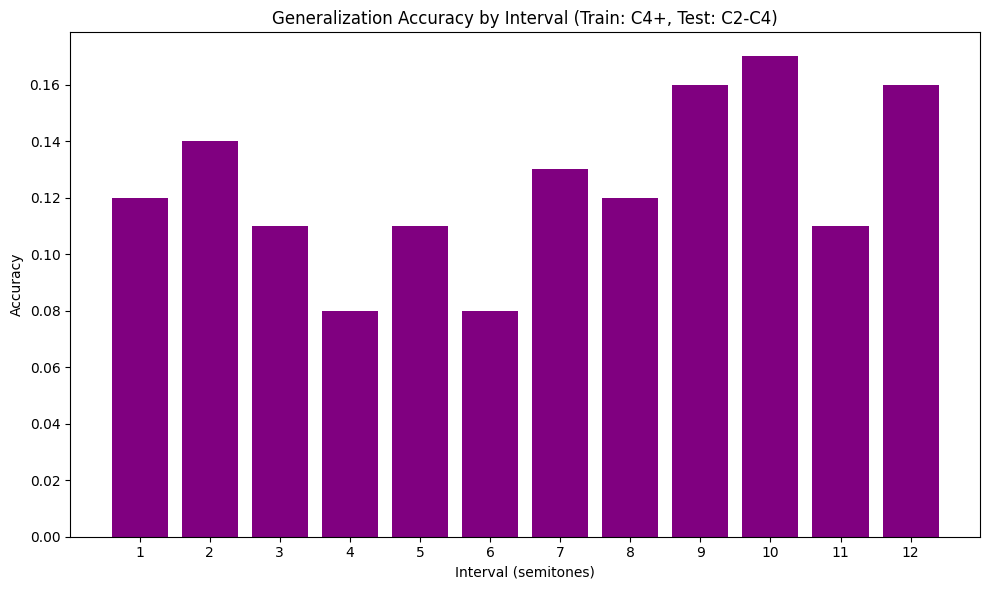

In [7]:
run_evaluate_saved_model()